# Sentiment Analysis of Stocktwits Messages using LSTM in PyTorch

## Introduction
When deciding the value of a company, it's important to follow the news. For example, a product recall or natural disaster in a company's product chain. You want to be able to turn this information into a signal. Currently, the best tool for the job is a Neural Network. 

For this project, you'll use posts from the social media site [StockTwits](https://en.wikipedia.org/wiki/StockTwits). The community on StockTwits is full of investors, traders, and entrepreneurs. Each message posted is called a Twit. This is similar to Twitter's version of a post, called a Tweet. You'll build a model around these twits that generate a sentiment score.

We've collected a bunch of twits, then hand labeled the sentiment of each. To capture the degree of sentiment, we'll use a five-point scale: very negative, negative, neutral, positive, very positive. Each twit is labeled -2 to 2 in steps of 1, from very negative to very positive respectively. You'll build a sentiment analysis model that will learn to assign sentiment to twits on its own, using this labeled data.

The first thing we should to do, is load the data.

### Load Packages

In [1]:
import json
import nltk
import os
import random
import re
import torch
import numpy as np
import pickle

from torch import nn, optim
import torch.nn.functional as F

## Import Twits 
### Load Twits Data 
This JSON file contains a list of objects for each twit in the `'data'` field:

```
{'data':
  {'message_body': 'Neutral twit body text here',
   'sentiment': 0},
  {'message_body': 'Happy twit body text here',
   'sentiment': 1},
   ...
}
```

The fields represent the following:

* `'message_body'`: The text of the twit.
* `'sentiment'`: Sentiment score for the twit, ranges from -2 to 2 in steps of 1, with 0 being neutral. 

Let's add a few helpful methods for storing and loading files publicly accessible on the internet or saved on the file system. They will be handy later on when we'd like to load pre-saved data in order to spare some processing time.

In [2]:
import json
import urllib.request

def save_file_if_missing(filename):
  if not os.path.exists(filename):
    response = load_file_from_external_source(filename)
    with open(filename, 'wb') as fp:
      fp.write(response.read())

def load_file_from_external_source(filename):
  if not os.path.exists(filename):
    URL = f'https://vkontech.com/post-sentiment-analysis/{filename}'
    request = urllib.request.Request(URL)
    # These headers are required as a workaround to download public files from Wordpress
    request.add_header('User-Agent', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36')
    resp = urllib.request.urlopen(request)
    return resp

def save_object_to_file(filename, content):
  with open(filename, 'wb') as fp:
      pickle.dump(content, fp)

def load_object_from_file(filename):
  with open(filename, 'rb') as fp:
    return pickle.load(fp)


Let's load the twits and print a few to the output.

In [3]:
twits_filename = 'twits.json'
if not os.path.exists(twits_filename):
  response = load_file_from_external_source(twits_filename)
  twits = json.load(response)
  save_object_to_file(twits_filename, twits)
else:
  twits = load_object_from_file(twits_filename)

twits['data'][:5]

[{'message_body': '$FITB great buy at 26.00...ill wait',
  'sentiment': 2,
  'timestamp': '2018-07-01T00:00:09Z'},
 {'message_body': '@StockTwits $MSFT',
  'sentiment': 1,
  'timestamp': '2018-07-01T00:00:42Z'},
 {'message_body': '#STAAnalystAlert for $TDG : Jefferies Maintains with a rating of Hold setting target price at USD 350.00. Our own verdict is Buy  http://www.stocktargetadvisor.com/toprating',
  'sentiment': 2,
  'timestamp': '2018-07-01T00:01:24Z'},
 {'message_body': '$AMD I heard there’s a guy who knows someone who thinks somebody knows something - on StockTwits.',
  'sentiment': 1,
  'timestamp': '2018-07-01T00:01:47Z'},
 {'message_body': '$AMD reveal yourself!',
  'sentiment': 0,
  'timestamp': '2018-07-01T00:02:13Z'}]

### Length of Data
Now let's look at the number of twits in dataset.

In [4]:
len(twits['data'])

1548010

### Split Message Body and Sentiment Score

In [5]:
messages = [twit['message_body'] for twit in twits['data']]
# Since the sentiment scores are discrete, we'll scale the sentiments to 0 to 4 for use in our network
sentiments = [twit['sentiment'] + 2 for twit in twits['data']]

## Preprocessing the Data
With our data in hand we need to preprocess our text. These twits are collected by filtering on ticker symbols where these are denoted with a leader $ symbol in the twit itself. For example,

`{'message_body': 'RT @google Our annual look at the year in Google blogging (and beyond) http://t.co/sptHOAh8 $GOOG',
 'sentiment': 0}`

The ticker symbols don't provide information on the sentiment, and they are in every twit, so we should remove them. This twit also has the `@google` username, again not providing sentiment information, so we should also remove it. We also see a URL `http://t.co/sptHOAh8`. Let's remove these too.

The easiest way to remove specific words or phrases is with regex using the `re` module. You can sub out specific patterns with a space:

```python
re.sub(pattern, ' ', text)
```
This will substitute a space with anywhere the pattern matches in the text. Later when we tokenize the text, we'll split appropriately on those spaces.

### Pre-Processing

In [6]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')


def preprocess(message):
    """
    This function takes a string as input, then performs these operations: 
        - lowercase
        - remove URLs
        - remove ticker symbols 
        - removes punctuation
        - tokenize by splitting the string on whitespace 
        - removes any single character tokens
    
    Parameters
    ----------
        message : The text message to be preprocessed.
        
    Returns
    -------
        tokens: The preprocessed text into tokens.
    """
    
    # Lowercase the twit message
    text = message.lower()
    
    # Replace URLs with a space in the message
    text = re.sub(r'https?://\S+', ' ', text)
    
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    text = re.sub(r'\$\S+', ' ', text)
    
    # Replace StockTwits usernames with a space. The usernames are any word that starts with @.
    text = re.sub(r'\@\S+', ' ', text)

    # Replace everything not a letter with a space
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    
    # Tokenize by splitting the string on whitespace into a list of words
    tokens = nltk.tokenize.word_tokenize(text)

    # Lemmatize words using the WordNetLemmatizer. You can ignore any word that is not longer than one character.
    wnl = nltk.stem.WordNetLemmatizer()
    tokens = [wnl.lemmatize(token) for token in tokens if len(token) > 1]

    
    assert type(tokens) == list, 'Tokens should be list'
    return tokens

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Preprocess All the Twits 
Now we can preprocess each of the twits in our dataset.

In [7]:
load_saved_token_list = True

In [8]:
tokenized_twits_filename = 'tokenList'

if load_saved_token_list:
  save_file_if_missing(tokenized_twits_filename)
else:
  tokenized_twits = [preprocess(message) for message in messages]
  save_object_to_file(tokenized_twits_filename, tokenized_twits)

tokenized_twits = load_object_from_file(tokenized_twits_filename)

tokenized_twits[:3]

[['great', 'buy', 'at', 'ill', 'wait'],
 [],
 ['staanalystalert',
  'for',
  'jefferies',
  'maintains',
  'with',
  'rating',
  'of',
  'hold',
  'setting',
  'target',
  'price',
  'at',
  'usd',
  'our',
  'own',
  'verdict',
  'is',
  'buy']]

### Bag of Words
Now with all of our messages tokenized, we want to create a vocabulary and count up how often each word appears in our entire corpus. Use the [`Counter`](https://docs.python.org/3.1/library/collections.html#collections.Counter) function to count up all the tokens.

In [9]:
from collections import Counter

"""
Create a vocabulary by using Bag of words
"""

tokenized_words = [word for twit in tokenized_twits for word in twit]

bow = Counter(tokenized_words)

### Frequency of Words Appearing in Message
With our vocabulary, now we'll remove some of the most common words such as 'the', 'and', 'it', etc. These words don't contribute to identifying sentiment and are really common, resulting in a lot of noise in our input. If we can filter these out, then our network should have an easier time learning.

We also want to remove really rare words that show up in a only a few twits. Here you'll want to divide the count of each word by the **number of messages** calculated in the code block above (i.e. `len(messages))`. Then remove words that only appear in some small fraction of the messages.

>Note: There is not an exact number for low and high-frequency cut-offs, however there is a correct optimal range.
You should ideally set up low-frequency cut-off from 0.0000002 to 0.000007 (inclusive) and high-frequency from 5 to 20 (inclusive). If the number is too big, we lose lots of important words that we can use in our data.

In [10]:
"""
Set the following variables:
    freqs
    low_cutoff
    high_cutoff
    K_most_common
"""

# Dictionary that contains the Frequency of words appearing in messages.
# The key is the token and the value is the frequency of that word in the corpus.
total_cnt = sum(bow.values())
freqs = dict(bow)

# Float that is the frequency cutoff. Drop words with a frequency that is lower or equal to this number.
low_cutoff = 5e-6

# Integer that is the cut off for most common words. Drop words that are the `high_cutoff` most common words.
high_cutoff = 15

# The k most common words in the corpus. Use `high_cutoff` as the k.
K_most_common = [word[0] for word in bow.most_common(high_cutoff)]


filtered_words = [word for word in freqs if (freqs[word] > low_cutoff and word not in K_most_common)]
print(K_most_common)
len(filtered_words) 

['the', 'to', 'is', 'for', 'on', 'of', 'and', 'in', 'this', 'it', 'at', 'will', 'up', 'are', 'you']


98359

### Updating Vocabulary by Removing Filtered Words
Let's creat three variables that will help with our vocabulary.

In [11]:
load_saved_filtered_twits = True

In [12]:
"""
Set the following variables:
    vocab
    id2vocab
    filtered
"""

# A dictionary for the `filtered_words`. The key is the word and value is an id that represents the word. 
vocab = {word:idx+1 for idx, word in enumerate(filtered_words)}
# Reverse of the `vocab` dictionary. The key is word id and value is the word. 
id2vocab = {idx:word for word, idx in vocab.items()}

filtered_twits_filename = 'filteredTwits'

if load_saved_filtered_twits:
  save_file_if_missing(filtered_twits_filename)
else:
  filtered = []
  for twit in tokenized_twits:
    filtered.append([word for word in twit if word in filtered_words])
  save_object_to_file(filtered)

filtered = load_object_from_file(filtered_twits_filename)

### Balancing the classes
Let's do a few last pre-processing steps. If we look at how our twits are labeled, we'll find that 50% of them are neutral. This means that our network will be 50% accurate just by guessing 0 every single time. To help our network learn appropriately, we'll want to balance our classes.
That is, make sure each of our different sentiment scores show up roughly as frequently in the data.

We should also take this opportunity to remove messages with length 0.

In [13]:
balanced = {'messages': [], 'sentiments':[]}

n_neutral = sum(1 for each in sentiments if each == 2)
N_examples = len(sentiments)
keep_prob = (N_examples - n_neutral)/4/n_neutral

for idx, sentiment in enumerate(sentiments):
    message = filtered[idx]
    if len(message) == 0:
        # skip this message because it has length zero
        continue
    elif sentiment != 2 or random.random() < keep_prob:
        balanced['messages'].append(message)
        balanced['sentiments'].append(sentiment) 

Check we did it correctly

In [14]:
n_neutral = sum(1 for each in balanced['sentiments'] if each == 2)
N_examples = len(balanced['sentiments'])
n_neutral/N_examples

0.19516929090748764

Finally let's convert our tokens into integer ids which we can pass to the network.

In [15]:
token_ids = [[vocab[word] for word in message] for message in balanced['messages']]
sentiments = balanced['sentiments']

## Neural Network
Now we have our vocabulary which means we can transform our tokens into ids, which are then passed to our network. So, let's define the network now!

The network architecture looks like so:


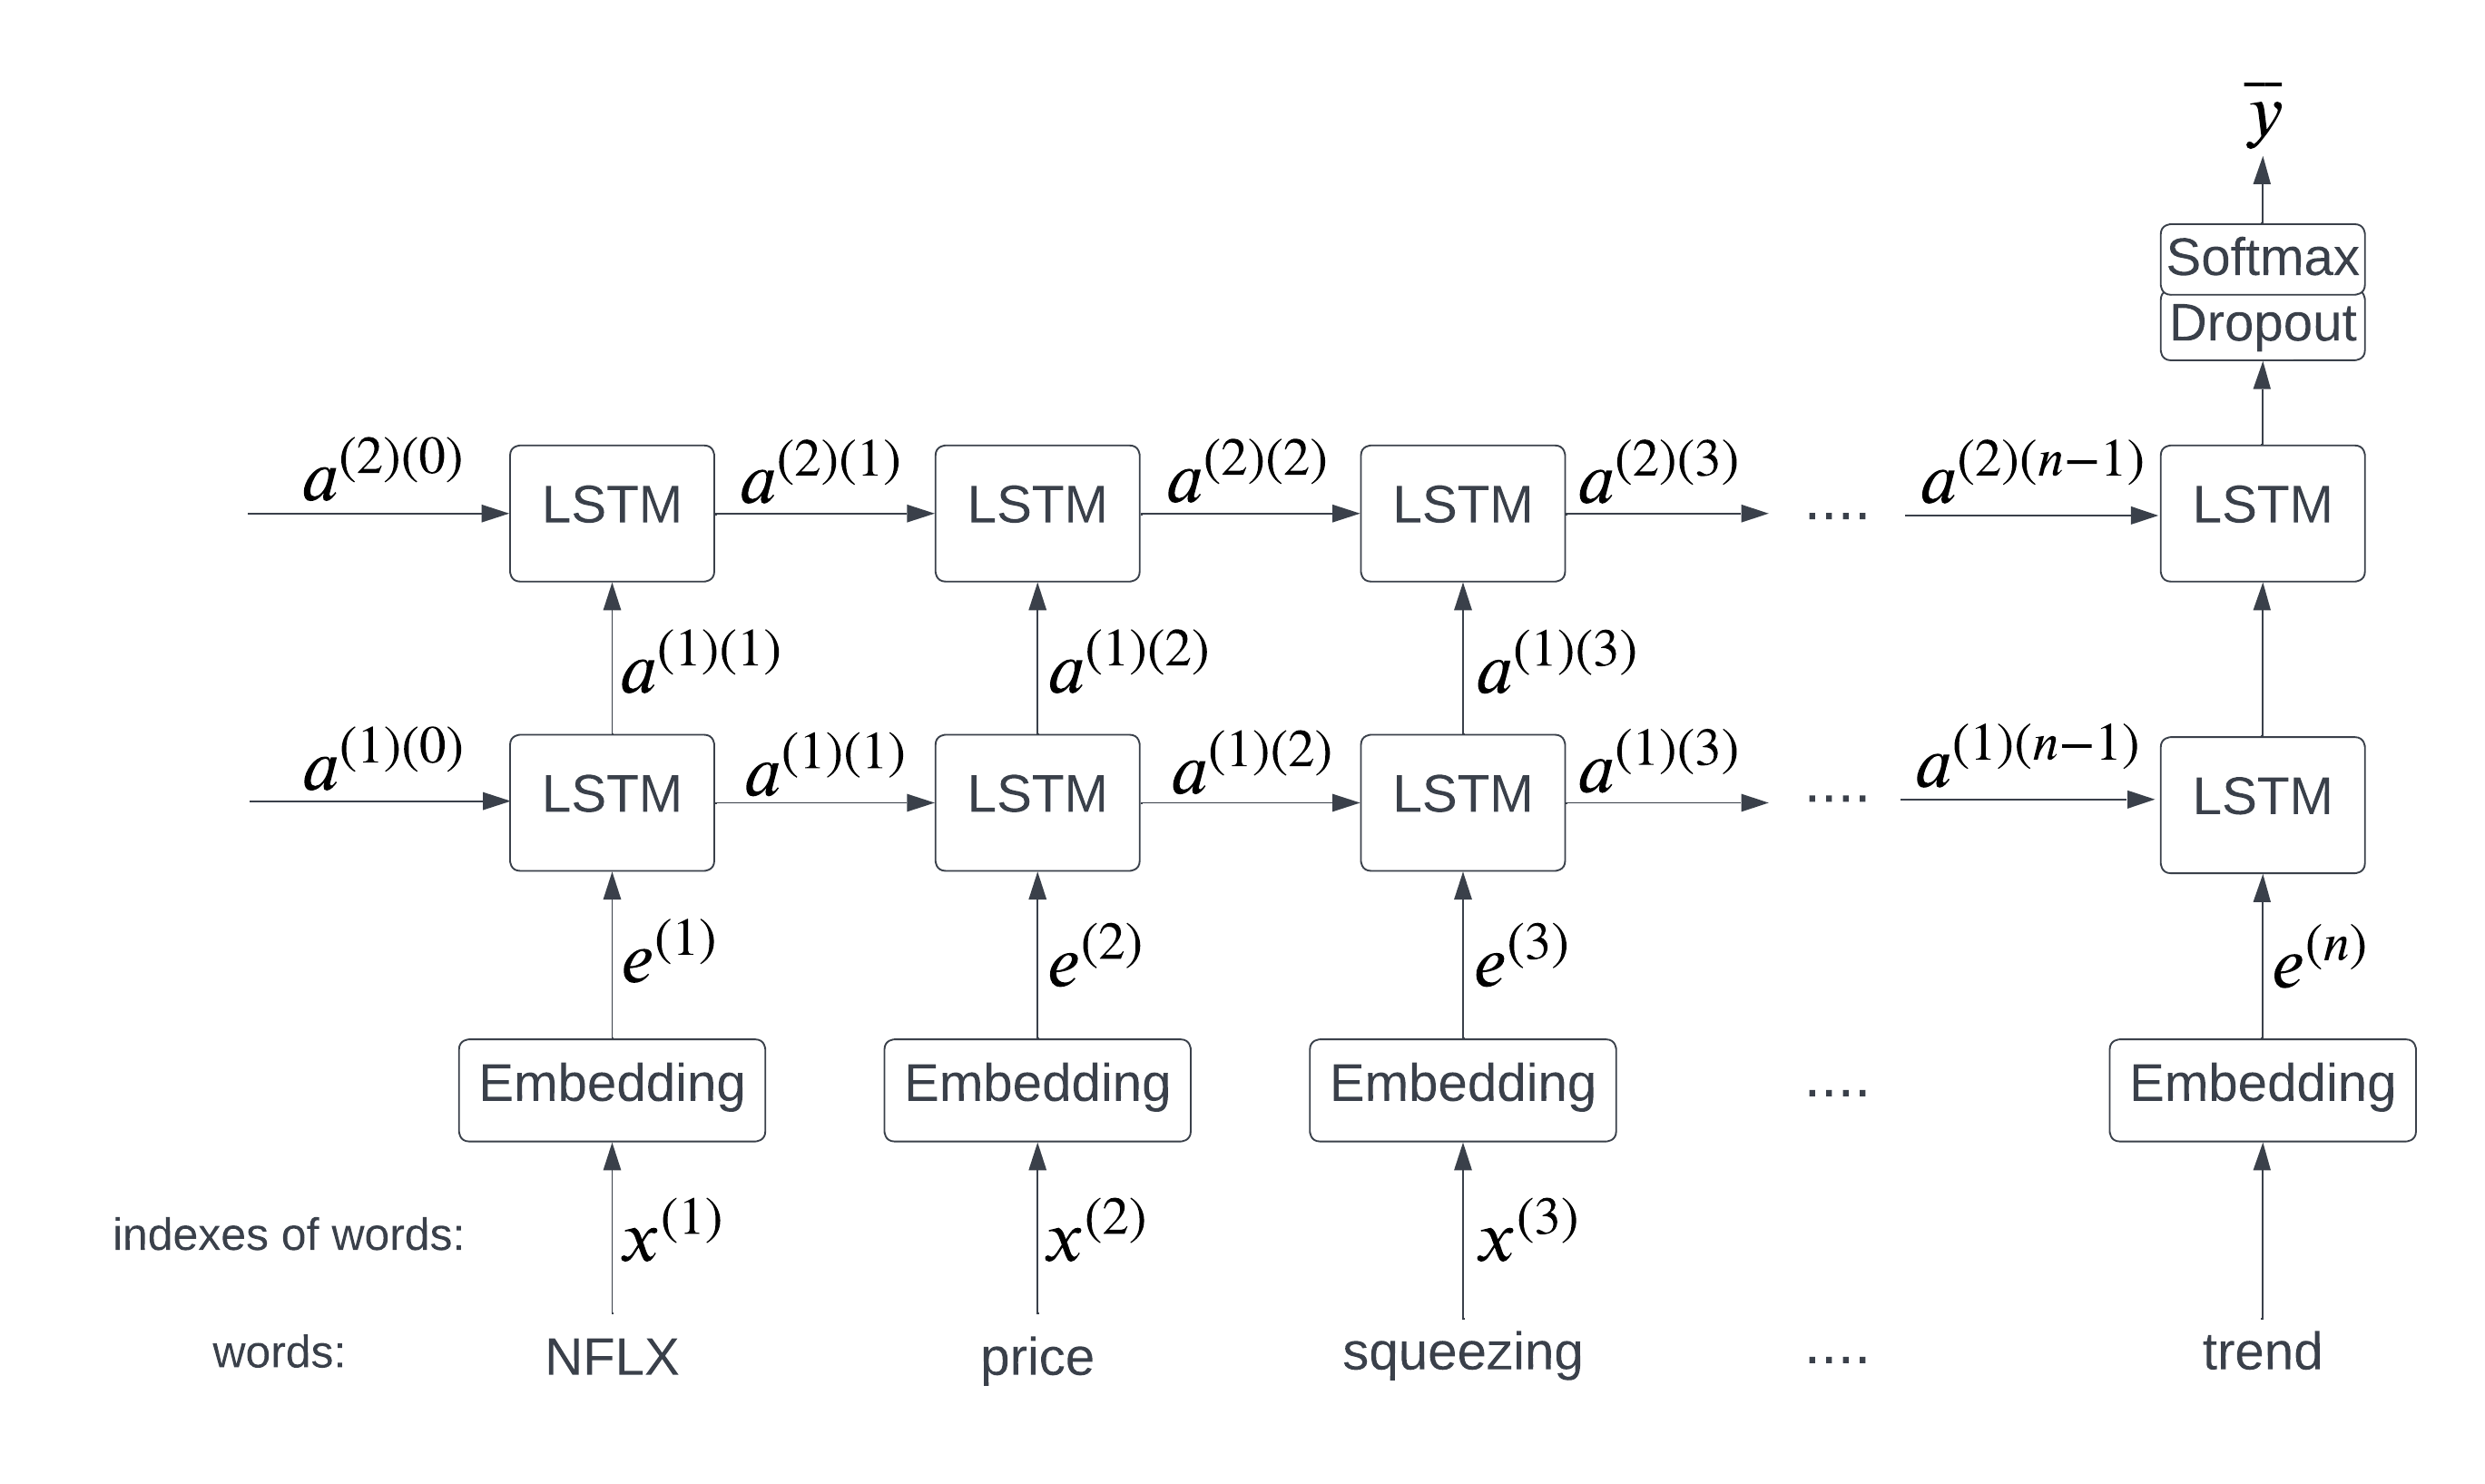

### Implement the text classifier
The network consists of three main parts: 1) init function `__init__` 2) forward pass `forward`  3) hidden state `init_hidden`. 

We are using `softmax` to find the probability for each outcome.

In [16]:
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

No GPU available, training on CPU.


In [17]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_size, output_size, lstm_layers=1, dropout=0.1):
        """
        Initialize the model by setting up the layers.
        
        Parameters
        ----------
            vocab_size : The vocabulary size.
            embed_size : The embedding layer size.
            lstm_size : The LSTM layer size.
            output_size : The output size.
            lstm_layers : The number of LSTM layers.
            dropout : The dropout probability.
        """
        
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.lstm_size = lstm_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout
        
        # Setup embedding layer ----------------------------------------------------------------------#
        self.embedding = nn.Embedding(num_embeddings= self.vocab_size, 
                                      embedding_dim = self.embed_size)
        
        # Setup additional layers
        self.lstm = nn.LSTM(input_size  = self.embed_size,
                            hidden_size = self.lstm_size,
                            num_layers  = self.lstm_layers,
                            batch_first = False,
                            dropout     = self.dropout)

        self.dropout = nn.Dropout(p=0.3)
        
        self.fc = nn.Linear(in_features = self.lstm_size, 
                            out_features= self.output_size)
        
        self.log_smax = nn.LogSoftmax(dim=1)

    def init_hidden(self, batch_size):
        """ 
        Initializes hidden state
        
        Parameters
        ----------
            batch_size : The size of batches.
        
        Returns
        -------
            hidden_state
            
        """
        
        weight = next(self.parameters()).data
        
        if train_on_gpu:
            hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_().cuda(),
                      weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_().cuda())
        else:
            hidden = (weight.new(self.lstm_layers,batch_size, self.lstm_size).zero_(),
                      weight.new(self.lstm_layers,batch_size, self.lstm_size).zero_())
        
        return hidden


    def forward(self, nn_input, hidden_state):
        """
        Perform a forward pass of our model on nn_input.
        
        Parameters
        ----------
            nn_input : The batch of input to the NN.
            hidden_state : The LSTM hidden state.

        Returns
        -------
            logps: log softmax output
            hidden_state: The new hidden state.
        """
        
        embed = self.embedding (nn_input)
        lstm_out, hidden_state = self.lstm(embed, hidden_state)
        lstm_out = lstm_out[-1]
        
        logps = self.log_smax(self.dropout(self.fc(lstm_out)))
        
        return logps, hidden_state

### View Model

In [18]:
model = TextClassifier(len(vocab), 10, 6, 5, dropout=0.1, lstm_layers=2)
model.embedding.weight.data.uniform_(-1, 1)
input = torch.randint(0, 1000, (5, 4), dtype=torch.int64)
if train_on_gpu:
    input = input.cuda()
    model.cuda()

hidden = model.init_hidden(4)

logps, _ = model.forward(input, hidden)
print(logps)

tensor([[-1.3983, -1.9213, -1.5688, -1.3755, -1.9273],
        [-1.4355, -1.4345, -1.6521, -1.6242, -2.0019],
        [-1.3791, -1.9333, -1.5766, -1.3791, -1.9307],
        [-1.4419, -1.4419, -1.6354, -1.6336, -1.9883]],
       grad_fn=<LogSoftmaxBackward0>)


## Training
### DataLoaders and Batching
Now we should build a generator that we can use to loop through our data. It'll be more efficient if we can pass our sequences in as batches. Our input tensors should look like `(sequence_length, batch_size)`. So if our sequences are 40 tokens long and we pass in 25 sequences, then we'd have an input size of `(40, 25)`.

If we set our sequence length to 40, what do we do with messages that are more or less than 40 tokens? For messages with fewer than 40 tokens, we will pad the empty spots with zeros. We should be sure to **left** pad so that the RNN starts from nothing before going through the data. If the message has 20 tokens, then the first 20 spots of our 40 long sequence will be 0. If a message has more than 40 tokens, we'll just keep the first 40 tokens.

In [19]:
def dataloader(messages, labels, sequence_length=30, batch_size=32, shuffle=False):
    """ 
    Build a dataloader.
    """
    if shuffle:
        indices = list(range(len(messages)))
        random.shuffle(indices)
        messages = [messages[idx] for idx in indices]
        labels = [labels[idx] for idx in indices]

    total_sequences = len(messages)

    for ii in range(0, total_sequences, batch_size):
        batch_messages = messages[ii: ii+batch_size]
        
        # First initialize a tensor of all zeros
        batch = torch.zeros((sequence_length, len(batch_messages)), dtype=torch.int64)
        for batch_num, tokens in enumerate(batch_messages):
            token_tensor = torch.tensor(tokens)
            # Left pad!
            start_idx = max(sequence_length - len(token_tensor), 0)
            batch[start_idx:, batch_num] = token_tensor[:sequence_length]
        
        label_tensor = torch.tensor(labels[ii: ii+len(batch_messages)])
        
        yield batch, label_tensor

### Training and  Validation
With our data in nice shape, we'll split it into training and validation sets.

In [20]:
n_training = int(0.8 * len(token_ids))
n_validation = int(0.1 * len(token_ids))

train_features = token_ids[:n_training]
valid_features = token_ids[n_training:n_training + n_validation]
train_labels = sentiments[:n_training]
valid_labels = sentiments[n_training:n_training + n_validation]

print(len(train_features), len(valid_labels))

825584 103198


In [21]:
text_batch, labels = next(iter(dataloader(train_features, train_labels, sequence_length=40, batch_size=512)))

model = TextClassifier(len(vocab)+1, 200, 128, 5, dropout=0.)
hidden = model.init_hidden(512)
if train_on_gpu:
    text_batch = text_batch.cuda()
    model.cuda()
logps, hidden = model.forward(text_batch, hidden)

### Training
It's time to train the neural network!

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TextClassifier(len(vocab)+1, 1024, 512, 5, lstm_layers=2, dropout=0.2)
model.embedding.weight.data.uniform_(-1, 1)
model.to(device)

TextClassifier(
  (embedding): Embedding(98360, 1024)
  (lstm): LSTM(1024, 512, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=5, bias=True)
  (log_smax): LogSoftmax(dim=1)
)

In [23]:
load_saved_model = True

In [24]:
model_filename = "modelExported"
if load_saved_model:
    save_file_if_missing(model_filename)
    if torch.cuda.is_available():
        map_location=lambda storage, loc: storage.cuda()
    else:
        map_location='cpu'
    model.load_state_dict(torch.load(model_filename, map_location=map_location))
    model.eval()
else:
    """
    Train your model with dropout. Make sure to clip your gradients.
    Print the training loss, validation loss, and validation accuracy for every 100 steps.
    """

    epochs = 2
    batch_size = 512
    sequence_length = 40
    learning_rate = 0.003
    clip = 5
    best_val_acc = 0

    print_every = 100
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(epochs):
        print('Starting epoch {}'.format(epoch + 1))

        steps = 0
        hidden = model.init_hidden(batch_size)

        for text_batch, labels in dataloader(
                train_features, train_labels, batch_size=batch_size, sequence_length=sequence_length, shuffle=True):
            if text_batch.size()!=torch.Size([sequence_length,batch_size]):
                continue
            steps += 1
            hidden = tuple([each.data for each in hidden])

            # Set Device
            text_batch, labels = text_batch.to(device), labels.to(device)
            for each in hidden:
                each.to(device)

            model.zero_grad()
            log_ps, hidden = model.forward(text_batch, hidden)
            loss = criterion(log_ps, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

            if steps % print_every == 0:
                model.eval()
                val_losses = []
                val_accuracy = []
                val_hidden = model.init_hidden(batch_size)

                for val_text_batch, val_labels in dataloader(
                valid_features, valid_labels, batch_size = batch_size, sequence_length = sequence_length):
                    if val_text_batch.size() != torch.Size([sequence_length, batch_size]):
                        continue
                    val_text_batch, val_labels = val_text_batch.to(device), val_labels.to(device)
                    val_hidden = tuple([each.data for each in val_hidden])
                    for each in val_hidden:
                        each.to(device)
                    val_log_ps, hidden = model.forward(val_text_batch, val_hidden)

                    val_loss = criterion(val_log_ps.squeeze(), val_labels)
                    val_losses.append(val_loss.item())

                    val_ps = torch.exp(val_log_ps)
                    top_p, top_class = val_ps.topk(1, dim=1)
                    equals = top_class == val_labels.view(*top_class.shape)
                    val_accuracy.append(torch.mean(equals.type(torch.FloatTensor)).item())

                # Print metrics
                model.train()
                this_val_acc = sum(val_accuracy)/len(val_accuracy)

                print("Epoch:{}/{}...".format(epoch+1, epochs),
                      "Step:{}...".format(steps),
                      "Loss:{:.6f}...".format(loss.item()),
                      "Val Loss:{:.6f}...".format(sum(val_losses)/len(val_losses)),
                      "Val Accuracy:{:.6f}...".format(this_val_acc))

    torch.save(model.state_dict(), "modelExported")

## Making Predictions
### Prediction 
Okay, now that you have a trained model, try it on some new twits and see if it works appropriately. Remember that for any new text, you'll need to preprocess it first before passing it to the network. Implement the `predict` function to generate the prediction vector from a message.

In [25]:
def predict(text, model, vocab):
    """ 
    Make a prediction on a single sentence.

    Parameters
    ----------
        text : The string to make a prediction on.
        model : The model to use for making the prediction.
        vocab : Dictionary for word to word ids. The key is the word and the value is the word id.

    Returns
    -------
        pred : Prediction vector
    """ 
    
    tokens = preprocess(text)
    
    # Filter non-vocab words
    tokens = [word for word in tokens if word in filtered_words]
    
    # Convert words to ids
    tokens = [vocab[word] for word in tokens]
        
    # Adding a batch dimension
    text_input = torch.tensor(tokens).unsqueeze(1)

    # Get the NN output
    hidden = model.init_hidden(text_input.size(1))
    logps, _ = model.forward(text_input,hidden)
    
    # Take the exponent of the NN output to get a range of 0 to 1 for each label.
    pred = torch.exp(logps)
    
    return pred.detach().numpy()

In [26]:
text = "Google is working on self driving cars, I'm bullish on $goog"
model.eval()
model.to("cpu")
predict(text, model, vocab)

array([[0.00165513, 0.01890535, 0.0102195 , 0.6906754 , 0.2785446 ]],
      dtype=float32)

You can see that the prediction returns a probability of 69% for the "positive" class and 28% for the "very positive" class.